In [1]:
# RESOURCES
# https://github.com/bentrevett/pytorch-seq2seq/tree/master
# https://github.com/Arturus/kaggle-web-traffic/blob/master/images/encoder-decoder.png

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import tensor

import matplotlib.pyplot as plt

import numpy as np
import random
from time import time
import math
from copy import deepcopy
import pandas as pd

In [3]:
device = 'cpu'

In [4]:
input_seq_length = 144
output_seq_length = 24

lr = 0.00005
num_epochs = 100
batch_size = 512
hidden_size = 32
num_gru_layers = 1
grad_clip = 1.0
scheduled_sampling_decay = 10
dropout = 0.

# As opposed to point-wise (assumes Gaussian)
probabilistic = True

use_attention = True

target_indices = [0]

In [5]:
# inverse sigmoid decay from https://arxiv.org/pdf/1506.03099.pdf
def inverse_sigmoid_decay(decay):
    def compute(indx):
        return decay / (decay + math.exp(indx / decay))
    return compute
calc_teacher_force_prob = inverse_sigmoid_decay(scheduled_sampling_decay)

f'At epoch {num_epochs} teacher force prob will be {calc_teacher_force_prob(num_epochs-1)}'

'At epoch 100 teacher force prob will be 0.0005014951969411607'

In [6]:
device = torch.device(device)

# Preprocessing

In [7]:
class TensorNormalizer:
    ''' Expects a 2d tensor to fit and transform '''
    def __init__(self, standardize=True):
        self.standardize = standardize
        # For z-score standardizing
        self.center = None
        self.std = None
        # For 0 to 1 normalizing
        self.mi = None
        self.range = None
    
    def _check(self, X, been_fit=False):
        assert len(X.shape) == 2
        if been_fit:
            if self.standardize: assert self.center is not None and self.std is not None
            else: assert self.range is not None and self.mi is not None
    
    def fit(self, X):
        self._check(X)
        if self.standardize:
            self.center = X.mean(axis=0)
            self.std = X.std(axis=0)
        else:
            self.mi = X.min(axis=0)[0]
            self.range = X.max(axis=0)[0] - self.mi
        return self
    
    def transform(self, X):
        self._check(X, been_fit=True)
        return (X - self.center) / self.std if self.standardize else (X - self.mi) / self.range
    
    def fit_transform(self, X):
        self.fit(X)
        return self, self.transform(X)
    
    def inverse_transform(self, X_scaled):
        self._check(X_scaled, been_fit=True)
        return (X_scaled * self.std) + self.center if self.standardize else (X_scaled * self.range) + self.mi
    
    def set_keep_columns(self, indices):
        if self.standardize:
            self.center = self.center[indices]
            self.std = self.std[indices]
        else:
            self.mi = self.mi[indices]
            self.range = self.range[indices]
    
    @staticmethod
    def debug():
        # Standardize
        original = tensor([[1, 2], [3, 4], [5, 6]], dtype=torch.float)
        scaler, scaled = TensorNormalizer(standardize=True).fit_transform(original)
        unscaled = scaler.inverse_transform(scaled)
        assert torch.equal(original, unscaled)
        # Normalize
        original = tensor([[1, 2], [3, 4], [5, 6]], dtype=torch.float)
        scaler, scaled = TensorNormalizer(standardize=False).fit_transform(original)
        unscaled = scaler.inverse_transform(scaled)
        assert torch.equal(original, unscaled)
TensorNormalizer.debug()

In [8]:
def load_data(device):
    # NOTE: Minus 1 so the lagged input to the decoder coorosponds to what the *target* looked like a period before
    period = 24 - 1
    df = np.expand_dims(pd.read_csv(f'data.csv', index_col=0).to_numpy().transpose(1, 0), 2)
    # Add period lag
    lag_time_series = []
    for time_series_indx in range(df.shape[0]):
        time_series_i = df[time_series_indx]
        lag = np.array([time_series_i[i - period, 0] for i in range(period, time_series_i.shape[0])])
        lag_time_series.append(lag)
    lag_time_series = np.expand_dims(np.stack(lag_time_series, 0), 2)
    df = df[:, period:, :]
    df = np.concatenate((df, lag_time_series), 2)
    # Tensor
    data = tensor(df, dtype=torch.float).to(device)
    # data: (num time series, timesteps, num features)
    return data

In [9]:
def split_data(data):
    num_timesteps = data.shape[1]
    train_end_indx = round(0.5 * num_timesteps)
    train_data = data[:, : train_end_indx]
    test_end_indx = train_end_indx + round(0.25 * num_timesteps)
    test_data = data[:, train_end_indx : test_end_indx]
    val_data = data[:, test_end_indx : ]
    return train_data, val_data, test_data

In [10]:
def create_sequences(data, input_seq_length, output_seq_length, target_indices):
    enc_inputs, dec_inputs, dec_targets, scalers = [], [], [], []
    # Loop over the starting timesteps of the sequences
    for timestep in range(data.shape[1] - (input_seq_length + output_seq_length) + 1):
        # enc_inputs: (num time series, input seq len, num features)
        enc_inputs_at_t = deepcopy(data[:, timestep : timestep + input_seq_length, :])
        dec_at_t = deepcopy(data[:, timestep + input_seq_length - 1 : timestep + input_seq_length + output_seq_length, :])
        # dec_targets: (num time series, output seq len, num features)
        dec_inputs_at_t = deepcopy(dec_at_t[:, :-1, :])
        # dec_targets: (num time series, output seq len, num targets)
        dec_targets_at_t = deepcopy(dec_at_t[:, 1:, target_indices])
        # Scale each time series separately
        all_ts_enc_inputs, all_ts_dec_inputs, all_ts_dec_targets, all_ts_scalers = [], [], [], []
        for ts_indx in range(enc_inputs_at_t.shape[0]):
            ts_scaler, ts_enc_inputs = TensorNormalizer(standardize=True).fit_transform(deepcopy(enc_inputs_at_t[ts_indx]))
            ts_dec_inputs = ts_scaler.transform(deepcopy(dec_inputs_at_t[ts_indx]))
            ts_scaler.set_keep_columns(target_indices)
            ts_dec_targets = ts_scaler.transform(deepcopy(dec_targets_at_t[ts_indx]))
            all_ts_enc_inputs.append(ts_enc_inputs); all_ts_dec_inputs.append(ts_dec_inputs)
            all_ts_dec_targets.append(ts_dec_targets); all_ts_scalers.append(ts_scaler)
        enc_inputs.append(torch.stack(all_ts_enc_inputs))
        dec_inputs.append(torch.stack(all_ts_dec_inputs))
        dec_targets.append(torch.stack(all_ts_dec_targets))
        scalers.append(np.stack(all_ts_scalers))
    enc_inputs = torch.stack(enc_inputs); dec_inputs = torch.stack(dec_inputs); 
    dec_targets = torch.stack(dec_targets); scalers = np.stack(scalers)
    # enc_inputs: (num seq by time, num time series, input seq len, num features)
    # dec_inputs: (num seq by time, num time series, output seq len, num features)
    # dec_targets: (num seq by time, num time series, output seq len, num targets)
    # scalers: (num seq by time, num time series)
    return {'enc_inputs': enc_inputs, 'dec_inputs': dec_inputs, 'dec_targets': dec_targets, 'scalers': scalers}

In [11]:
def add_time_series_identifier_feature(data, device):
    # Add time series categorical identifier
    num_time_series = float(data['enc_inputs'].shape[1])
    def add_column(data_element):
        new_column = []
        for time_series_indx in range(data_element.shape[1]):
            time_series_identifier = time_series_indx / num_time_series
            time_series_identifier = torch.full((data_element.shape[0], data_element.shape[2], 1), time_series_identifier).to(device)
            new_column.append(time_series_identifier)
        new_column = torch.stack(new_column, dim=1)
        return torch.cat((data_element, new_column), dim=3)
    data['enc_inputs'] = add_column(data['enc_inputs'])
    data['dec_inputs'] = add_column(data['dec_inputs'])
    return data

In [12]:
def reshape_data(data):
    # data: (num time series)
    for k, v in data.items():
        if k == 'scalers':
            data[k] = v.reshape(-1)
        else:
            data[k] = v.reshape(-1, v.shape[2], v.shape[3])
    return data

In [13]:
# Load raw data
data = load_data(device)
data.shape

torch.Size([4, 8737, 2])

In [14]:
# Split into train/val/test
data_splits = split_data(data)
data_splits[0].shape, data_splits[1].shape, data_splits[2].shape

(torch.Size([4, 4368, 2]), torch.Size([4, 2185, 2]), torch.Size([4, 2184, 2]))

In [15]:
# Create the sequences
data_splits = create_sequences(data_splits[0], input_seq_length, output_seq_length, target_indices), \
               create_sequences(data_splits[1], input_seq_length, output_seq_length, target_indices), \
               create_sequences(data_splits[2], input_seq_length, output_seq_length, target_indices)
data_splits[0]['enc_inputs'].shape

torch.Size([4201, 4, 144, 2])

In [16]:
# Add time series indentifier (for multiple time series training)
data_splits = add_time_series_identifier_feature(data_splits[0], device), \
                    add_time_series_identifier_feature(data_splits[1], device), \
                        add_time_series_identifier_feature(data_splits[2], device)
data_splits[0]['enc_inputs'].shape, data_splits[0]['dec_inputs'].shape

(torch.Size([4201, 4, 144, 3]), torch.Size([4201, 4, 24, 3]))

In [17]:
# Reshape to stack different time series
train_data, val_data, test_data = reshape_data(data_splits[0]), reshape_data(data_splits[1]), reshape_data(data_splits[2])

In [18]:
train_data['enc_inputs'].shape, val_data['enc_inputs'].shape, test_data['enc_inputs'].shape

(torch.Size([16804, 144, 3]),
 torch.Size([8072, 144, 3]),
 torch.Size([8068, 144, 3]))

In [19]:
train_data['enc_inputs'].shape, train_data['dec_inputs'].shape, train_data['dec_targets'].shape, train_data['scalers'].shape

(torch.Size([16804, 144, 3]),
 torch.Size([16804, 24, 3]),
 torch.Size([16804, 24, 1]),
 (16804,))

# Model

In [20]:
def layer_init(layer, w_scale=1.0):
    nn.init.kaiming_uniform_(layer.weight.data)
    layer.weight.data.mul_(w_scale)
    nn.init.constant_(layer.bias.data, 0.)
    return layer

In [21]:
class Encoder(nn.Module):
    def __init__(self, enc_feature_size, hidden_size, num_gru_layers, dropout):
        super().__init__()
        self.gru = nn.GRU(enc_feature_size, hidden_size, num_gru_layers, batch_first=True, dropout=dropout)
        
    def forward(self, inputs):
        # inputs: (batch size, input seq len, num enc features)
        output, hidden = self.gru(inputs)
            
        # output: (batch size, input seq len, hidden size)
        # hidden: (num gru layers, batch size, hidden size)
        return output, hidden

In [22]:
# Decoder superclass whose forward is called by Seq2Seq but other methods filled out by subclasses
class DecoderBase(nn.Module):
    def __init__(self, device, dec_target_size, target_indices, dist_size, probabilistic):
        super().__init__()
        self.device = device
        self.target_indices = target_indices
        self.target_size = dec_target_size
        self.dist_size = dist_size
        self.probabilistic = probabilistic
    
    # Have to run one step at a time unlike with the encoder since sometimes not teacher forcing
    def run_single_recurrent_step(self, inputs, hidden, enc_outputs):
        raise NotImplementedError()
    
    def forward(self, inputs, hidden, enc_outputs, teacher_force_prob=None):
        # inputs: (batch size, output seq length, num dec features)
        # hidden: (num gru layers, batch size, hidden dim), ie the last hidden state
        # enc_outputs: (batch size, input seq len, hidden size)
        
        batch_size, dec_output_seq_length, _ = inputs.shape
        
        # Store decoder outputs
        # outputs: (batch size, output seq len, num targets, num dist params)
        outputs = torch.zeros(batch_size, dec_output_seq_length, self.target_size, dist_size, dtype=torch.float).to(self.device)

        # curr_input: (batch size, 1, num dec features)
        curr_input = inputs[:, 0:1, :]
        
        for t in range(dec_output_seq_length):
            # dec_output: (batch size, 1, num targets, num dist params)
            # hidden: (num gru layers, batch size, hidden size)
            dec_output, hidden = self.run_single_recurrent_step(curr_input, hidden, enc_outputs)
            # Save prediction
            outputs[:, t:t+1, :, :] = dec_output
            # dec_output: (batch size, 1, num targets)
            dec_output = Seq2Seq.sample_from_output(dec_output)
            
            # If teacher forcing, use target from this timestep as next input o.w. use prediction
            teacher_force = random.random() < teacher_force_prob if teacher_force_prob is not None else False
            
            curr_input = inputs[:, t:t+1, :].clone()
            if not teacher_force:
                curr_input[:, :, self.target_indices] = dec_output
        return outputs

In [23]:
class DecoderVanilla(DecoderBase):
    def __init__(self, dec_feature_size, dec_target_size, hidden_size, 
                 num_gru_layers, target_indices, dropout, dist_size,
                 probabilistic, device):
        super().__init__(device, dec_target_size, target_indices, dist_size, probabilistic)
        self.gru = nn.GRU(dec_feature_size, hidden_size, num_gru_layers, batch_first=True, dropout=dropout)
        self.out = layer_init(nn.Linear(hidden_size + dec_feature_size, dec_target_size * dist_size))
    
    def run_single_recurrent_step(self, inputs, hidden, enc_outputs):
        # inputs: (batch size, 1, num dec features)
        # hidden: (num gru layers, batch size, hidden size)
        
        output, hidden = self.gru(inputs, hidden)
        output = self.out(torch.cat((output, inputs), dim=2))
        output = output.reshape(output.shape[0], output.shape[1], self.target_size, self.dist_size)
        
        # output: (batch size, 1, num targets, num dist params)
        # hidden: (num gru layers, batch size, hidden size)
        return output, hidden

In [24]:
class Attention(nn.Module):
    def __init__(self, hidden_size, num_gru_layers):
        super().__init__()
        # NOTE: the hidden size for the output of attn (and input of v) can actually be any number  
        # Also, using two layers allows for a non-linear act func inbetween
        self.attn = nn.Linear(2 * hidden_size, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)
    
    def forward(self, decoder_hidden_final_layer, encoder_outputs):
        # decoder_hidden_final_layer: (batch size, hidden size)
        # encoder_outputs: (batch size, input seq len, hidden size)
        
        # Repeat decoder hidden state input seq len times
        hidden = decoder_hidden_final_layer.unsqueeze(1).repeat(1, encoder_outputs.shape[1], 1)
        
        # Compare decoder hidden state with each encoder output using a learnable tanh layer
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        
        # Then compress into single values for each comparison (energy)
        attention = self.v(energy).squeeze(2)
        
        # Then softmax so the weightings add up to 1
        weightings = F.softmax(attention, dim=1)
                
        # weightings: (batch size, input seq len)
        return weightings

In [25]:
class DecoderWithAttention(DecoderBase):
    def __init__(self, dec_feature_size, dec_target_size, hidden_size, 
                 num_gru_layers, target_indices, dropout, dist_size,
                 probabilistic, device):
        super().__init__(device, dec_target_size, target_indices, dist_size, probabilistic)
        self.attention_model = Attention(hidden_size, num_gru_layers)
        # GRU takes previous timestep target and weighted sum of encoder hidden states
        self.gru = nn.GRU(dec_feature_size + hidden_size, hidden_size, num_gru_layers, batch_first=True, dropout=dropout)
        # Output layer takes decoder hidden state output, weighted sum and decoder input
        # NOTE: Feeding decoder input into the output layer essentially acts as a skip connection
        self.out = layer_init(nn.Linear(hidden_size + hidden_size + dec_feature_size, dec_target_size * dist_size))

    def run_single_recurrent_step(self, inputs, hidden, enc_outputs):
        # inputs: (batch size, 1, num dec features)
        # hidden: (num gru layers, batch size, hidden size)
        # enc_outputs: (batch size, input seq len, hidden size)
        
        # Get attention weightings
        # weightings: (batch size, input seq len)
        weightings = self.attention_model(hidden[-1], enc_outputs)
        
        # Then compute weighted sum
        # weighted_sum: (batch size, 1, hidden size)
        weighted_sum = torch.bmm(weightings.unsqueeze(1), enc_outputs)
                
        # Then input into GRU
        # gru inputs: (batch size, 1, num dec features + hidden size)
        # output: (batch size, 1, hidden size)
        output, hidden = self.gru(torch.cat((inputs, weighted_sum), dim=2), hidden)
            
        # Get prediction
        # out input: (batch size, 1, hidden size + hidden size + num targets)
        output = self.out(torch.cat((output, weighted_sum, inputs), dim=2))
        output = output.reshape(output.shape[0], output.shape[1], self.target_size, self.dist_size)
        
        # output: (batch size, 1, num targets, num dist params)
        # hidden: (num gru layers, batch size, hidden size)
        return output, hidden

In [26]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, lr, grad_clip, probabilistic):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

        self.opt = torch.optim.Adam(self.parameters(), lr)
        self.loss_func = nn.GaussianNLLLoss() if probabilistic else nn.L1Loss()
        self.grad_clip = grad_clip

        self.probabilistic = probabilistic
    
    @staticmethod
    def compute_smape(prediction, target):
        return torch.mean(torch.abs(prediction - target) / ((torch.abs(target) + torch.abs(prediction)) / 2. + 1e-8)) * 100.
    
    @staticmethod
    def get_dist_params(output):
        mu = output[:, :, :, 0]
        # softplus to constrain to positive
        sigma = F.softplus(output[:, :, :, 1])
        return mu, sigma
    
    @staticmethod
    def sample_from_output(output):
        # in - output: (batch size, dec seq len, num targets, num dist params)
        # out - output: (batch size, dec seq len, num targets)
        if output.shape[-1] > 1:  # probabilistic can be assumed
            mu, sigma = Seq2Seq.get_dist_params(output)
            return torch.normal(mu, sigma)
        # No sample just reshape if pointwise
        return output.squeeze(-1)
    
    def forward(self, enc_inputs, dec_inputs, teacher_force_prob=None):
        # enc_inputs: (batch size, input seq length, num enc features)
        # dec_inputs: (batch size, output seq length, num dec features)
        
        # enc_outputs: (batch size, input seq len, hidden size)
        # hidden: (num gru layers, batch size, hidden dim), ie the last hidden state
        enc_outputs, hidden = self.encoder(enc_inputs)
        
        # outputs: (batch size, output seq len, num targets, num dist params)
        outputs = self.decoder(dec_inputs, hidden, enc_outputs, teacher_force_prob)
        
        return outputs

    def compute_loss(self, prediction, target, override_func=None):
        # prediction: (batch size, dec seq len, num targets, num dist params)
        # target: (batch size, dec seq len, num targets)
        if self.probabilistic:
            mu, sigma = Seq2Seq.get_dist_params(prediction)
            var = sigma ** 2
            loss = self.loss_func(mu, target, var)
        else:
            loss = self.loss_func(prediction.squeeze(-1), target)
        return loss if self.training else loss.item()
    
    def optimize(self, prediction, target):
        # prediction & target: (batch size, seq len, output dim)
        self.opt.zero_grad()
        loss = self.compute_loss(prediction, target)
        loss.backward()
        if self.grad_clip is not None:
            torch.nn.utils.clip_grad_norm_(self.parameters(), self.grad_clip)
        self.opt.step()
        return loss.item()

# Run Training

In [27]:
# New generator every epoch
def batch_generator(data, batch_size, unscale=False):
    enc_inputs, dec_inputs, dec_targets, scalers = \
        data['enc_inputs'], data['dec_inputs'], data['dec_targets'], data['scalers']
    indices = torch.randperm(enc_inputs.shape[0])
    for i in range(0, len(indices), batch_size):
        batch_indices = indices[i : i + batch_size]
        batch_enc_inputs = enc_inputs[batch_indices]
        batch_dec_inputs = dec_inputs[batch_indices]
        batch_dec_targets = dec_targets[batch_indices]
        batch_scalers = None
        if unscale:
            batch_scalers = scalers[batch_indices]
            # Weird np and torch behavior if batch size is 1
            if isinstance(batch_scalers, TensorNormalizer): batch_scalers = np.array([batch_scalers])
        # No remainder
        if batch_enc_inputs.shape[0] < batch_size:
            break
        yield batch_enc_inputs, batch_dec_inputs, batch_dec_targets, batch_scalers

In [28]:
def train(model, train_data, batch_size, teacher_force_prob):
    model.train()
    
    epoch_loss = 0.
    num_batches = 0
    
    for batch_enc_inputs, batch_dec_inputs, batch_dec_targets, _ in batch_generator(train_data, batch_size):
        output = model(batch_enc_inputs, batch_dec_inputs, teacher_force_prob)
        loss = model.optimize(output, batch_dec_targets)
        
        epoch_loss += loss
        num_batches += 1
    return epoch_loss / num_batches

In [29]:
def evaluate(model, val_data, batch_size):
    model.eval()
    
    epoch_loss = 0.
    num_batches = 0
    
    with torch.no_grad():
        for batch_enc_inputs, batch_dec_inputs, batch_dec_targets, _ in batch_generator(val_data, batch_size):
            output = model(batch_enc_inputs, batch_dec_inputs)
            loss = model.compute_loss(output, batch_dec_targets)

            epoch_loss += loss
            num_batches += 1
        
    return epoch_loss / num_batches

In [30]:
dist_size = 2 if probabilistic else 1
enc_feature_size = train_data['enc_inputs'].shape[-1]
dec_feature_size = train_data['dec_inputs'].shape[-1]
dec_target_size = train_data['dec_targets'].shape[-1]

encoder = Encoder(enc_feature_size, hidden_size, num_gru_layers, dropout)
decoder_args = (dec_feature_size, dec_target_size, hidden_size, num_gru_layers, target_indices, dropout, dist_size, probabilistic, device)
decoder = DecoderWithAttention(*decoder_args) if use_attention else DecoderVanilla(*decoder_args)
seq2seq = Seq2Seq(encoder, decoder, lr, grad_clip, probabilistic).to(device)

In [31]:
best_val, best_model = float('inf'), None
for epoch in range(num_epochs):
    start_t = time()
    teacher_force_prob = calc_teacher_force_prob(epoch)
    train_loss = train(seq2seq, train_data, batch_size, teacher_force_prob)
    val_loss = evaluate(seq2seq, val_data, batch_size)

    new_best_val = False
    if val_loss < best_val:
        new_best_val = True
        best_val = val_loss
        best_model = deepcopy(seq2seq)
    print(f'Epoch {epoch+1} => Train loss: {train_loss:.5f},',
          f'Val: {val_loss:.5f},',
          f'Teach: {teacher_force_prob:.2f},',
          f'Took {(time() - start_t):.1f} s{"      (NEW BEST)" if new_best_val else ""}')

Epoch 1 => Train loss: 1.09604, Val: 1.16216, Teach: 0.91, Took 23.5 s      (NEW BEST)
Epoch 2 => Train loss: 0.91404, Val: 1.01028, Teach: 0.90, Took 23.1 s      (NEW BEST)
Epoch 3 => Train loss: 0.77431, Val: 0.91222, Teach: 0.89, Took 22.8 s      (NEW BEST)
Epoch 4 => Train loss: 0.66967, Val: 0.82213, Teach: 0.88, Took 22.7 s      (NEW BEST)
Epoch 5 => Train loss: 0.59055, Val: 0.75423, Teach: 0.87, Took 24.3 s      (NEW BEST)
Epoch 6 => Train loss: 0.52989, Val: 0.70387, Teach: 0.86, Took 22.9 s      (NEW BEST)
Epoch 7 => Train loss: 0.48298, Val: 0.66004, Teach: 0.85, Took 22.9 s      (NEW BEST)
Epoch 8 => Train loss: 0.45035, Val: 0.63882, Teach: 0.83, Took 23.0 s      (NEW BEST)
Epoch 9 => Train loss: 0.42412, Val: 0.62511, Teach: 0.82, Took 23.6 s      (NEW BEST)
Epoch 10 => Train loss: 0.39632, Val: 0.60840, Teach: 0.80, Took 23.7 s      (NEW BEST)
Epoch 11 => Train loss: 0.37761, Val: 0.61105, Teach: 0.79, Took 22.4 s
Epoch 12 => Train loss: 0.36057, Val: 0.60676, Teach: 0.7

# Test Evaluation

In [32]:
data_to_eval = test_data

In [33]:
# Baselines & Best Model

best_model.eval()

mean_losses, norm_losses, repeat_losses, trained_model_losses = [], [], [], []
for batch_enc_inputs, batch_dec_inputs, batch_dec_targets, _ in batch_generator(data_to_eval, 32):

    # Inputs mean baseline
    mean_baseline_preds = torch.repeat_interleave(batch_enc_inputs[:, :, target_indices].mean(axis=1, keepdims=True), data_to_eval['dec_targets'].shape[1], 1).unsqueeze(-1)
    if probabilistic:
        stds = torch.zeros(mean_baseline_preds.shape, dtype=torch.float).to(device)
        mean_baseline_preds = torch.cat((mean_baseline_preds, stds), dim=3)
    mean_loss = best_model.compute_loss(mean_baseline_preds, batch_dec_targets)

    # Normal dist from inputs mean and std
    test_inputs = batch_enc_inputs[:, :, target_indices]
    test_inputs_mean = torch.repeat_interleave(test_inputs.mean(axis=1, keepdims=True), batch_dec_targets.shape[1], 1).unsqueeze(-1)
    test_inputs_std = torch.repeat_interleave(test_inputs.std(axis=1, keepdims=True), batch_dec_targets.shape[1], 1).unsqueeze(-1)
    if probabilistic:
        norm_baseline_preds = torch.cat((test_inputs_mean, test_inputs_std), dim=3)
    else:
        norm_baseline_preds = torch.normal(test_inputs_mean, test_inputs_std)
    norm_loss = best_model.compute_loss(norm_baseline_preds, batch_dec_targets)

    # Repeat last input
    repeat_baseline_preds = torch.repeat_interleave(batch_enc_inputs[:, -1:, target_indices], batch_dec_targets.shape[1], 1).unsqueeze(-1)
    if probabilistic:
        stds = torch.zeros(repeat_baseline_preds.shape, dtype=torch.float).to(device)
        repeat_baseline_preds = torch.cat((repeat_baseline_preds, stds), dim=3)
    repeat_loss = best_model.compute_loss(repeat_baseline_preds, batch_dec_targets)

    # Best model
    outputs = best_model(batch_enc_inputs, batch_dec_inputs)
    trained_model_loss = best_model.compute_loss(outputs, batch_dec_targets)

    mean_losses.append(mean_loss); norm_losses.append(norm_loss)
    repeat_losses.append(repeat_loss); trained_model_losses.append(trained_model_loss)
np.mean(mean_losses), np.mean(norm_losses), np.mean(repeat_losses), np.mean(trained_model_losses)

(0.7332765195104811,
 0.5788921056285737,
 1.589984730595634,
 -0.6511665886593243)

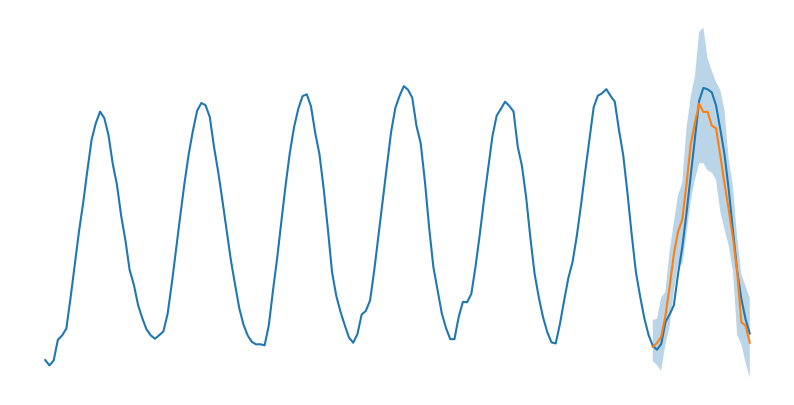

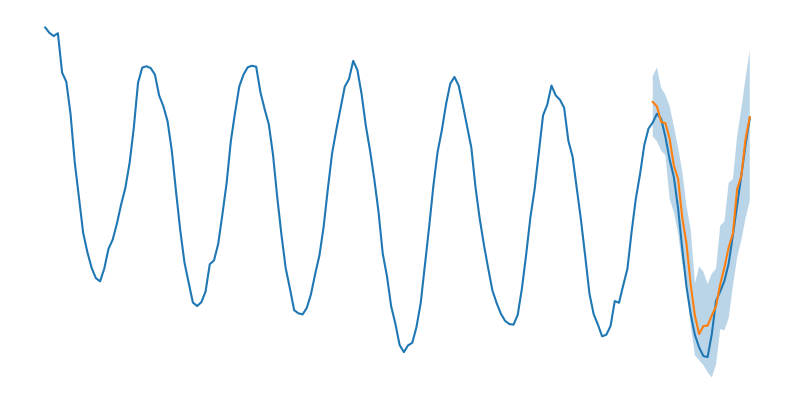

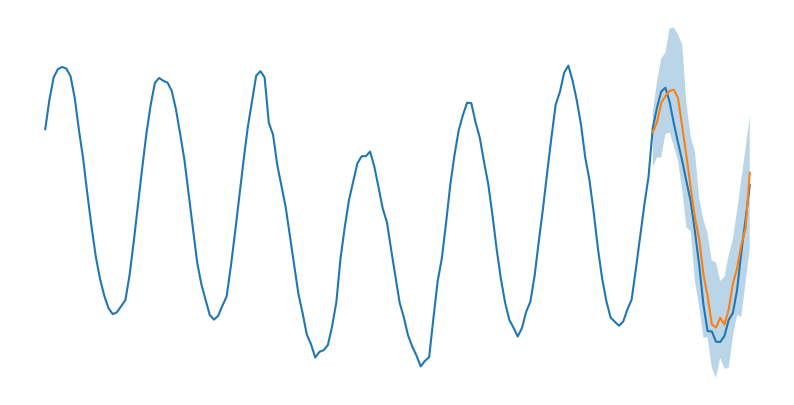

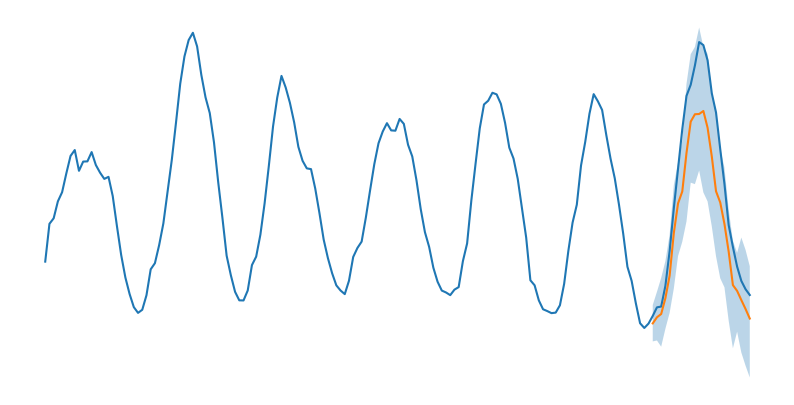

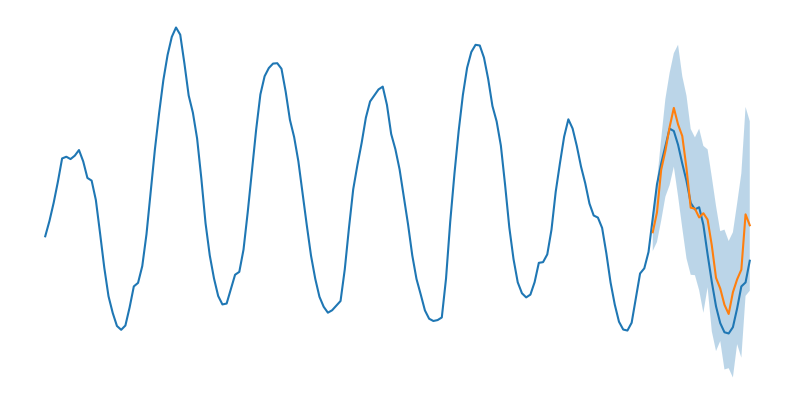

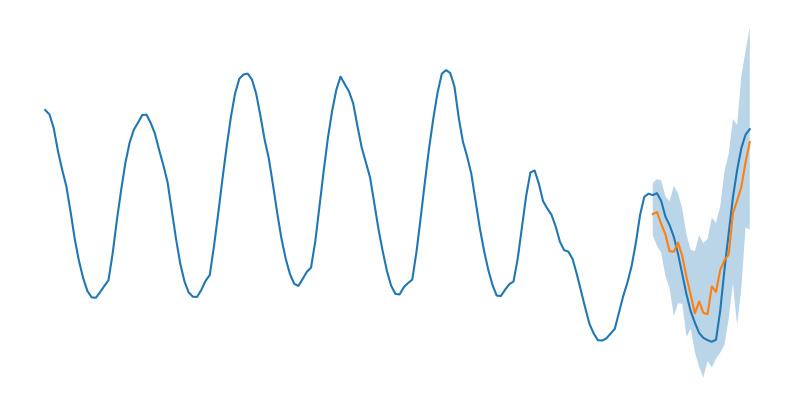

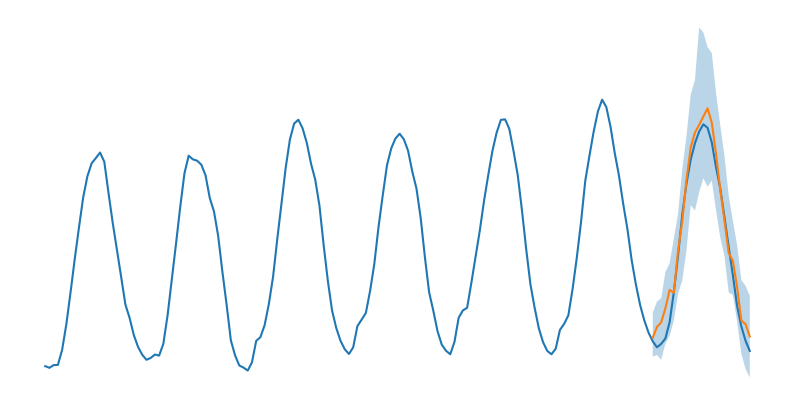

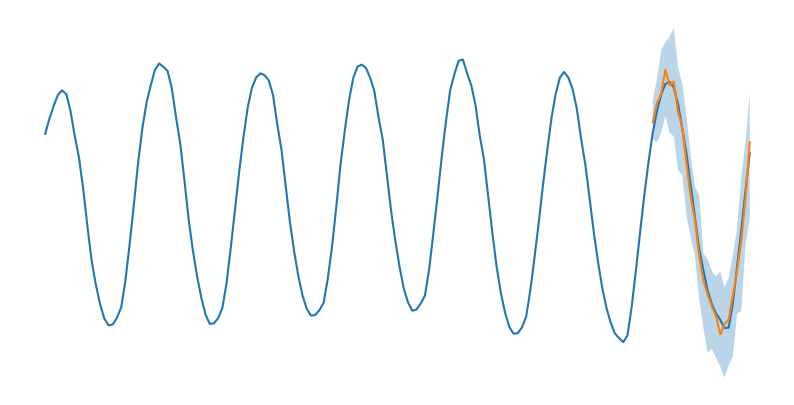

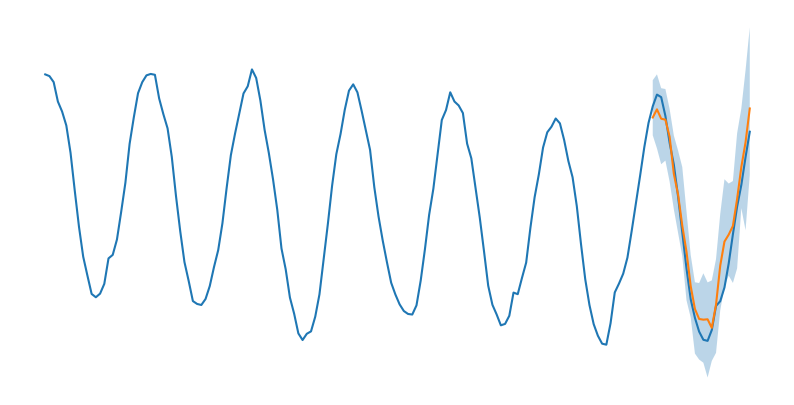

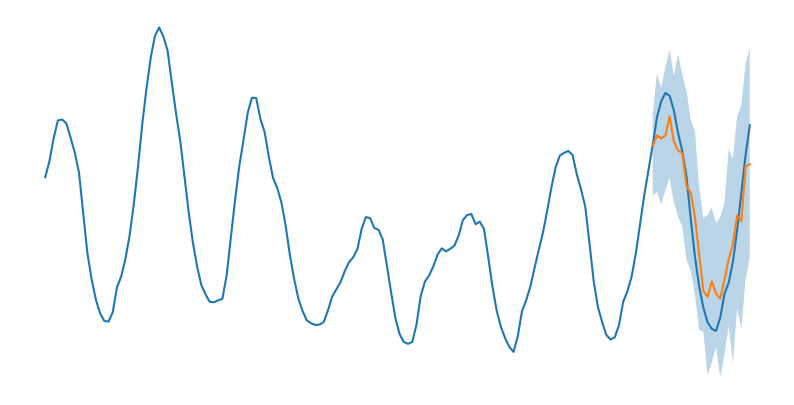

In [34]:
# Visualize
target_to_vis = 0
num_vis = 10
num_rollouts = 50 if probabilistic else 1

best_model.eval()

with torch.no_grad():
    batch_enc_inputs, batch_dec_inputs, batch_dec_targets, scalers = next(batch_generator(data_to_eval, num_vis, unscale=True))

    outputs = []
    for r in range(num_rollouts):
        outputs.append(Seq2Seq.sample_from_output(best_model(batch_enc_inputs, batch_dec_inputs)))
    outputs = torch.stack(outputs, dim=1)

for indx in range(batch_enc_inputs.shape[0]):
    scaler = scalers[indx]
    sample_enc_inputs, sample_dec_inputs, sample_dec_targets = \
        scaler.inverse_transform(batch_enc_inputs[indx])[:, target_to_vis].cpu().numpy().tolist(),\
            scaler.inverse_transform(batch_dec_inputs[indx])[:, target_to_vis].cpu().numpy().tolist(), \
                scaler.inverse_transform(batch_dec_targets[indx])[:, target_to_vis].cpu().numpy().tolist()
    output_rollouts = []
    for output_rollout in outputs[indx]:
        output_rollouts.append(scaler.inverse_transform(output_rollout)[:, target_to_vis].cpu().numpy().tolist())
    output_rollouts = np.array(output_rollouts)

    plt.figure(figsize=(10,5))
    x = list(range(len(sample_enc_inputs) + len(sample_dec_targets)))
    # Plot inputs
    plt.plot(x, sample_enc_inputs + sample_dec_targets)
    # Plot median
    output_x = list(range(len(sample_enc_inputs), len(x)))
    plt.plot(output_x, np.median(output_rollouts, axis=0))
    # Plot quantiles
    plt.fill_between(
        output_x,
        np.quantile(output_rollouts, 0.05, axis=0), 
        np.quantile(output_rollouts, 0.95, axis=0), 
        alpha=0.3, 
        interpolate=True
    )
    plt.gca().set_axis_off()
    plt.show()